**`VANILLA GAN`**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  **A Generative Adversarial Network (GAN) is a deep learning architecture that consists of two neural networks competing against each other in a zero-sum game framework. The goal of GANs is to generate new, synthetic data that resembles some known data distribution.**

# In GANs, there is a **Generator** and a **Discriminator**. The Generator generates fake samples of data(be it an image, audio, etc.) and tries to fool the Discriminator. The Discriminator, on the other hand, tries to distinguish between the real and fake samples. The Generator and the Discriminator are both Neural Networks and they both run in competition with each other in the training phase. The steps are repeated several times and in this, the Generator and Discriminator get better and better in their respective jobs after each repetition.



Vanilla GAN:
---
# This is the simplest type of GAN. Here, the Generator and the Discriminator are simple multi-layer perceptrons. In vanilla GAN, the algorithm is really simple, it tries to optimize the mathematical equation using stochastic gradient descent.

In [29]:

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from keras.models import load_model


import matplotlib.pyplot as plt
from numpy.random import randint
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
import cv2
import os
from tqdm import tqdm

In [3]:
img_rows = 64
img_cols = 64
channels = 3
img_shape = (img_rows, img_cols, channels)
dLosses = []
gLosses = []

In [4]:
def define_discriminator(in_shape=(img_shape)):  # Discriminator is similar to a binary classifier which classifies whether an image is real/fake
                                               #Given an input image, the Discriminator outputs the likelihood of the image being real.

    discriminator = Sequential()
    discriminator.add(Flatten(input_shape=in_shape))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(0.0002, 0.5)
    discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return discriminator

test_discr = define_discriminator()                                 # An image is given as input, Discriminator returns the image and its validity as output.
                                                                     #The validity is the Discriminator’s guess of input being real or not.
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 512)               6291968   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [5]:
def define_generator(latent_dim):


#Define your generator network
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.
    noise_shape = (latent_dim,)
    generator  = Sequential()
    generator.add(Dense(256, input_shape=noise_shape))  # Noise is given as input to the sequential model
    generator.add(LeakyReLU(alpha=0.2))                 #Alpha — α is a hyperparameter which controls the underlying value to which the function saturates negatives network inputs.
    generator.add(Dense(512))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dense(np.prod(img_shape), activation='tanh'))
    generator.add(Reshape(img_shape))
    return generator

test_gen = define_generator(100)
print(test_gen.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 12288)            

In [6]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [7]:
dataset_dir = '/work/assignment/a3_gan/dataset_a3/align-cropped/img_align_celeba_png'

def load_dataset(dataset_dir):
    images = []
    for filename in tqdm(os.listdir(dataset_dir)):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(dataset_dir, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            img = cv2.resize(img, (64, 64))  # Resize images to a consistent size
            img = img.astype('float32')
            img = (img - 255) / 255
            images.append(img)
    return np.array(images)

In [8]:
def generate_real_samples(dataset, half_batch):
	# choose random images
	ix = randint(0, dataset.shape[0], half_batch)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((half_batch, 1)) ##Label=1 indicating they are real
	return X, y

In [9]:
def generate_latent_points(latent_dim, half_batch):
	# generate points in the latent space
	x_input = randn(latent_dim * half_batch)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(half_batch, latent_dim) #
	return x_input

In [10]:
# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, half_batch):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, half_batch)
	# print(x_input.shape) 																	#(64,100)
	# predict using generator to generate fake samples.
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake.
	y = zeros((half_batch, 1))  #Label=0 indicating they are fake
	return X, y

In [11]:
# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator.
#Feed both set of images into the Discriminator.
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss.
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)


	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples (64)
                            #and a half batch of fake samples, combined a single batch . Manually enumerate epochs and bacthes.
	for i in range(n_epochs): 	# enumerate batches over the training set
		for j in range(bat_per_epo):
             																	  # Train the discriminator on real and fake images, separately (half batch each)
        																				#Research showed that separate training is more effective.
																								# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)

																							# update discriminator model weights
            																	##train_on_batch allows you to update weights based on a collection of samples you provide
            																	#Let us just capture loss and ignore accuracy value (2nd output below)
			#print(y_real.shape) #(64,1)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
																							# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
																						# update discriminator model weights


			#print(X_fake.shape) #(64, 28, 28, 1)
			#print(y_fake.shape) #(64,1)
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
																						 #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            																	# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

             																	# The generator wants the discriminator to label the generated samples as valid (ones)
        																			#This is where the generator is trying to trick discriminator into believing
        																			#the generated image is true (hence value of 1 for y)
			#print(X_gan.shape) #(128,100)
			y_gan = ones((n_batch, 1))
            																	# Generator is part of combined model where it got directly linked with the discriminator
        																			# Train the generator with latent_dim as x and 1 as y.
        																			# Again, 1 as the output as it is adversarial and if generator did a great
       																				 #job of folling the discriminator then the output would be 1 (true)
																									# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
																						  # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('face_generator_20.h5')


In [ ]:
dataset = load_dataset(dataset_dir)

bat_per_epo = int(dataset.shape[0] / 128)
bat_per_epo

half_batch = int(128 / 2)
half_batch

np.save('dataset', dataset)

  0%|          | 0/202599 [00:00<?, ?it/s]

100%|██████████| 202599/202599 [05:31<00:00, 611.29it/s]


64

In [ ]:
np.load('dataset.npy')

dataset.shape

(202599, 64, 64, 3)

In [16]:
# size of the latent space
latent_dim = 100

In [ ]:
###################################################################
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
# dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=20)

################################################################################

2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 1/1582, d1=0.473, d2=0.719 g=0.831
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 2/1582, d1=0.000, d2=5.999 g=0.021
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 3/1582, d1=0.000, d2=6.804 g=0.032
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 4/1582, d1=0.000, d2=5.159 g=0.231
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 5/1582, d1=0.000, d2=5.240 g=1.040
2/2 [==============================] - 0s 4ms/step
Epoch>1, Batch 6/1582, d1=0.008, d2=5.874 g=1.085
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 7/1582, d1=0.200, d2=3.794 g=4.199
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 8/1582, d1=0.003, d2=1.673 g=2.889
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 9/1582, d1=0.010, d2=4.079 g=0.470
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch 10/1582, d1=0.008, d2=6.6

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
generator = load_model('/content/drive/MyDrive/Colab Notebooks/face_generator_20.h5')

# Generate random noise
n = 5
num_images_to_generate = n * n  # You can change this to generate more or fewer images
random_noise = np.random.normal(0, 1, size=(num_images_to_generate, latent_dim))

# Generate images
generated_images = generator.predict(random_noise)

1/1 [==============================] - 0s 425ms/step


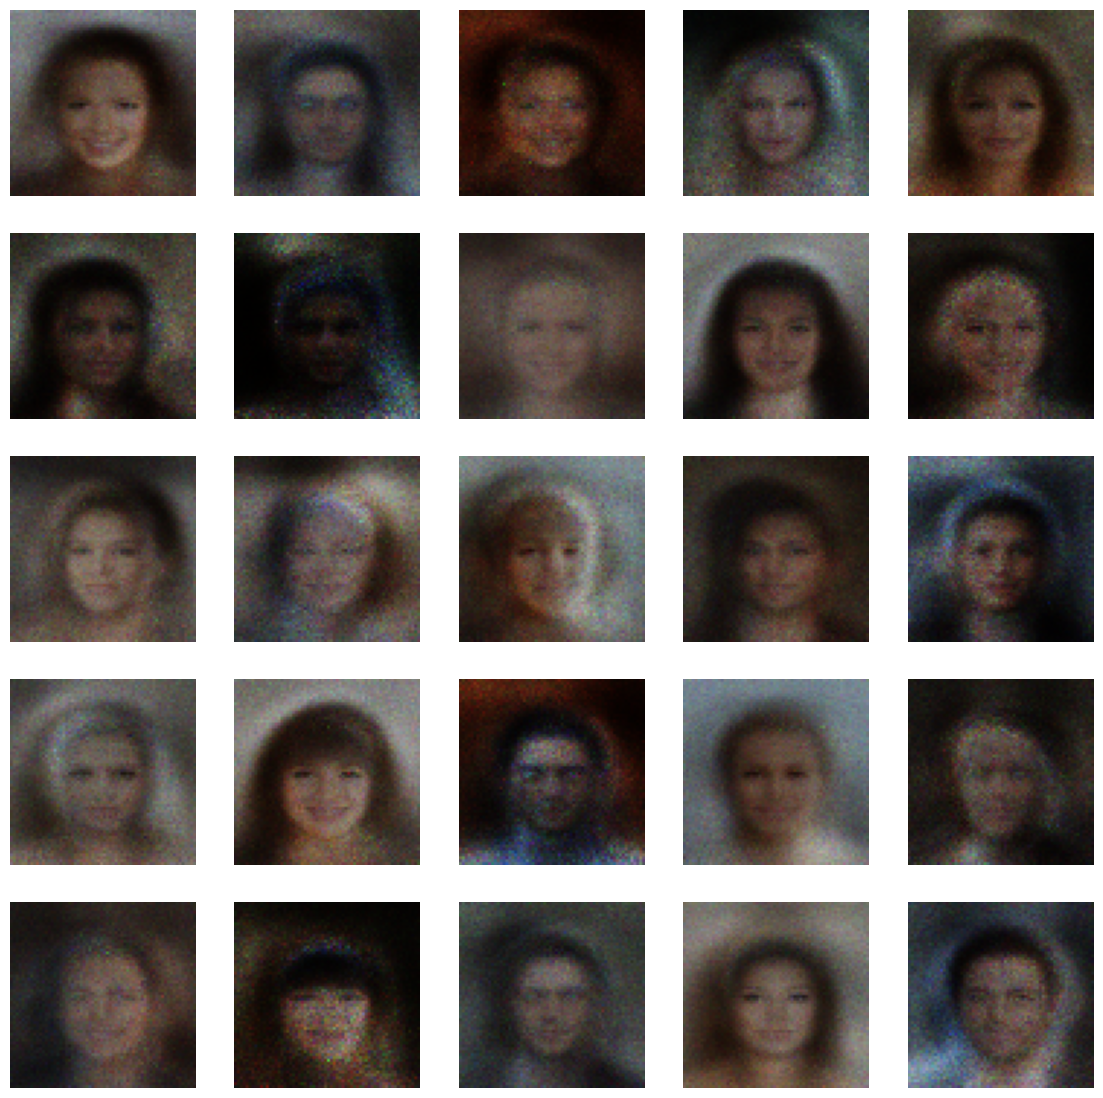

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))
for i in range(num_images_to_generate):
    plt.subplot(n, n, i + 1)
    plt.imshow((generated_images[i] + 1) / 2)  # Rescale to [0, 1]
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 130ms/step


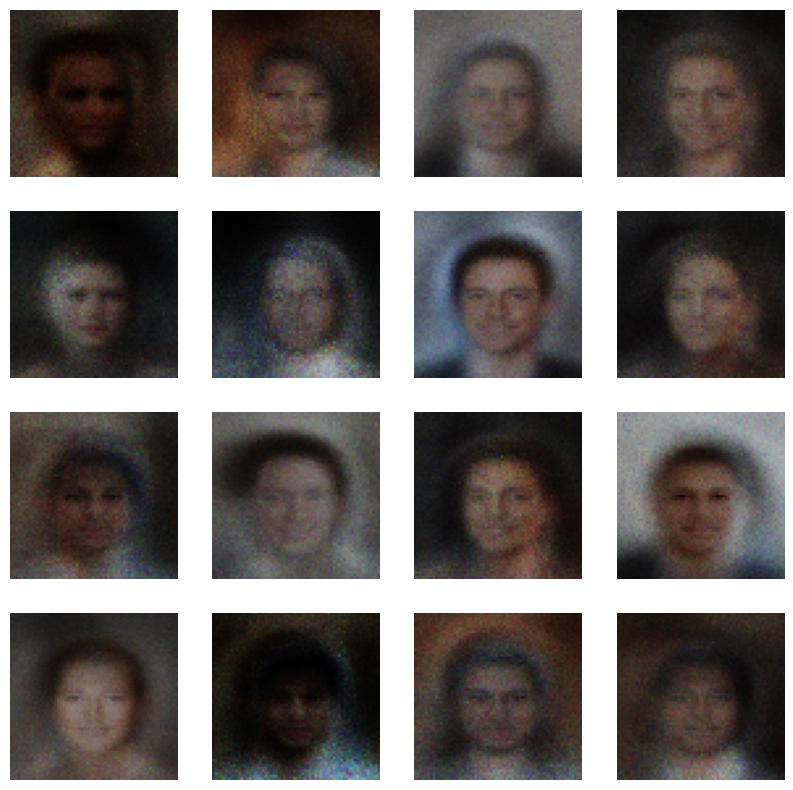

In [27]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # Reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Create and save a plot of generated images
def save_plot(examples, n):
    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        # Define subplot
        plt.subplot(n, n, 1 + i)
        # Turn off axis
        plt.axis('off')
        # Plot the image
        plt.imshow(examples[i])
    plt.show()

# Load the model
model = load_model('/content/drive/MyDrive/Colab Notebooks/face_generator_20.h5')

# Generate images
# Generate 16 images, each image provides a vector of size 100 as input
latent_points = generate_latent_points(100, 16)

# Generate images
X = model.predict(latent_points)

# Rescale the values to [0, 255] and change the data type to uint8
X = ((X + 1) / 2.0 * 255).astype('uint8')

# Plot the result
save_plot(X, 4)  # Plot a 4x4 grid (Change to 5 if generating 25 images)
